In [98]:

import os
import copy
import time
import itertools as it

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from sortedcontainers import SortedDict

# Implementation of Basic function

Here is some basic function to tranform SAT file to weighted_adjacency matrix and get clique from graph.

In [99]:
def read_sat(sat_path):
    with open(sat_path) as f:
        sat_lines = f.readlines()
        header = sat_lines[0]
        header_info = header.replace("\n", "").split(" ")
        vars_num = int(header_info[-2])
        clauses_num = int(header_info[-1])

        sat = [
            [int(x) for x in line.replace(" 0\n", "").split(" ")]
            for line in sat_lines[1:]
        ]

        return vars_num, clauses_num, sat


def sat_to_lig_adjacency_matrix(sat, num_vars):
    def get_literal_idx(x): return 2 * x - 2 if x > 0 else 2 * abs(x) - 1
    lig_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    lig_weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    
    for clause in sat:
        pairs = it.combinations(clause, 2)
        for x, y in pairs:
            x_idx = get_literal_idx(x)
            y_idx = get_literal_idx(y)
            lig_adjacency_matrix[x_idx, y_idx] = 1
            lig_adjacency_matrix[y_idx, x_idx] = 1
            lig_weighted_adjacency_matrix[x_idx, y_idx] += 1
            lig_weighted_adjacency_matrix[y_idx, x_idx] += 1

    return lig_weighted_adjacency_matrix


def get_cliques(graph, k):
    cliques = nx.enumerate_all_cliques(graph)
    clique_candidates = []
    for clique in cliques:
        if len(clique) <= k:
            if len(clique) > 1:
                clique_candidates.append(clique)
        else:
            break
    return clique_candidates


def cliques_to_weighted_adjacency_matrix(cliques, num_vars):
    weighted_adjacency_matrix = np.zeros([2*num_vars, 2*num_vars])
    for clique in cliques:
        pairs = it.combinations(clique, 2)
        for pair in pairs:
            x_idx = pair[0]
            y_idx = pair[1]

            weighted_adjacency_matrix[x_idx, y_idx] += 1
            weighted_adjacency_matrix[y_idx, x_idx] += 1

    return weighted_adjacency_matrix


def objective(x, y):
    return np.abs(x - y).sum()/np.count_nonzero(x)




# Convenience function: `run`

As like TSP notebook, I will define `run` to run a clique cover operator (algorithm) on given: weighted adjacency matrix, valid_cliques, and select_clique_num.

In [100]:
def run(cover_opt, instance, weighted_adjacency_matrix, max_clique_size, select_clique_num, num_vars):
    print(f"{'<' * 8} {instance} {'>' * 8}")
    # get the valid cliques from weighted_adjacency_matrix (graph)
    start_time = time.time()
    graph = nx.from_numpy_array(weighted_adjacency_matrix)
    valid_cliques  = get_cliques(graph, max_clique_size)
    print(f'cliques enumerate time: {time.time() - start_time:.4f}')
    print(f'valid cliques num: {len(valid_cliques)}')

    # select cliques from valid cliques from the valid cliques
    # your cover_opt will be used in here
    start_time = time.time()
    select_cliques = cover_opt(copy.deepcopy(weighted_adjacency_matrix), valid_cliques, select_clique_num, max_clique_size)
    print(f'cliques cover time: {time.time() - start_time:.4f}')

    # convert the selected cliques to weighted matrix and compare to the given weigthed matrix
    weighted_adjacency_matrix_cover = cliques_to_weighted_adjacency_matrix(select_cliques, num_vars)
    print(f'final objective: {objective(weighted_adjacency_matrix, weighted_adjacency_matrix_cover):.4f}\n') 

# Implement and evaluate your algorithm

Your algortihm will be evaluate on three graphs (sat instances).

In [101]:
# AVL Tree generated by gpt4 :)
class Node:
    def __init__(self, data):
        self.left = None
        self.right = None
        self.data = data
        self.height = 1

class AVLTree:
    def __init__(self):
        self.root = None

    def get_height(self, root):
        if not root:
            return 0
        return root.height

    def get_min_value_node(self, root):
        if root is None or root.left is None:
            return root
        return self.get_min_value_node(root.left)

    def get_balance(self, root):
        if not root:
            return 0
        return self.get_height(root.left) - self.get_height(root.right)

    def add(self, id, val):
        def _add(root, id, val):
            if not root:
                return Node((id, val))
            if id < root.data[0]:
                root.left = _add(root.left, id, val)
            else:
                root.right = _add(root.right, id, val)
            root.height = 1 + max(self.get_height(root.left), self.get_height(root.right))
            balance = self.get_balance(root)
            if balance > 1 and id < root.left.data[0]:
                return self.rotate_right(root)
            if balance < -1 and id > root.right.data[0]:
                return self.rotate_left(root)
            if balance > 1 and id > root.left.data[0]:
                root.left = self.rotate_left(root.left)
                return self.rotate_right(root)
            if balance < -1 and id < root.right.data[0]:
                root.right = self.rotate_right(root.right)
                return self.rotate_left(root)
            return root
        self.root = _add(self.root, id, val)

    def delete(self, id):
        def _delete(root, id):
            if not root:
                return root
            elif id < root.data[0]:
                root.left = _delete(root.left, id)
            elif id > root.data[0]:
                root.right = _delete(root.right, id)
            else:
                if not root.left:
                    temp = root.right
                    root = None
                    return temp
                elif not root.right:
                    temp = root.left
                    root = None
                    return temp
                temp = self.get_min_value_node(root.right)
                root.data = temp.data
                root.right = _delete(root.right, temp.data[0])
            if not root:
                return root
            root.height = 1 + max(self.get_height(root.left), self.get_height(root.right))
            balance = self.get_balance(root)
            if balance > 1 and self.get_balance(root.left) >= 0:
                return self.rotate_right(root)
            if balance < -1 and self.get_balance(root.right) <= 0:
                return self.rotate_left(root)
            if balance > 1 and self.get_balance(root.left) < 0:
                root.left = self.rotate_left(root.left)
                return self.rotate_right(root)
            if balance < -1 and self.get_balance(root.right) > 0:
                root.right = self.rotate_right(root.right)
                return self.rotate_left(root)
            return root
        self.root = _delete(self.root, id)

    def get_max_value_index(self):
        if not self.root:
            return None
        node = self.root
        while node.right:
            node = node.right
        return node.data[0]

    def rotate_right(self, z):
        y = z.left
        T3 = y.right
        y.right = z
        z.left = T3
        z.height = 1 + max(self.get_height(z.left), self.get_height(z.right))
        y.height = 1 + max(self.get_height(y.left), self.get_height(y.right))
        return y

    def rotate_left(self, z):
        y = z.right
        T2 = y.left
        y.left = z
        z.right = T2
        z.height = 1 + max(self.get_height(z.left), self.get_height(z.right))
        y.height = 1 + max(self.get_height(y.left), self.get_height(y.right))
        return y
    
    def find(self, key):
        return self._find(self.root, key)

    def _find(self, node, key):
        if not node:
            return None

        if key < node.data[0]:
            return self._find(node.left, key)
        elif key > node.data[0]:
            return self._find(node.right, key)
        else:
            return node.data[1]

In [102]:
# write you code in here

def naive_clique_cover(weighted_adjacency_matrix, valid_cliques, select_clique_num):
    return valid_cliques[:select_clique_num]
# the below code will evaluate your algorithm

def update_clique_value (clique_value, cliques):
    for clique_index in cliques:
        
        new_val = clique_value.find(clique_index)
        if new_val != None:
            clique_value.delete(clique_index)
            clique_value.add(clique_index, new_val - 2)
    

def clique_cover (weighted_adjacency_matrix, valid_cliques, select_clique_num, max_clique_size):
    e = weighted_adjacency_matrix.copy()
    random.shuffle(valid_cliques)
    #valid_cliques = sorted(valid_cliques, key = lambda x: -len(x))
    c2 = np.zeros(max_clique_size + 1)
    for i in range(1, max_clique_size + 1):
        c2[i] = i * (i - 1) / 2
        
    
    edge_to_clique = dict()
    clique_value = AVLTree()
    for index, clique in enumerate(valid_cliques):
        for i in range(len(clique)):
            for j in range(i + 1, len(clique)):
                if (clique[i], clique[j]) not in edge_to_clique:
                    edge_to_clique[(clique[i], clique[j])] = []
                edge_to_clique[(clique[i], clique[j])].append(index)
        clique_value.add(index, c2[len(clique)])       # at the beginning, every clique has the full contribute to answer
        
    select_cliques = []
    for _ in range(3):#range(select_clique_num):
        cur_index = clique_value.get_max_value_index()
        cur_clique = valid_cliques[cur_index]
        print(cur_clique)
        for i in range(len(cur_clique)):
            for j in range(i + 1, len(cur_clique)):
                e[cur_clique[i]][cur_clique[j]] -= 1
                if e[cur_clique[i]][cur_clique[j]] == 0:
                    update_clique_value(clique_value, edge_to_clique[(cur_clique[i], cur_clique[j])])                                
        select_cliques.append(cur_clique)
        clique_value.delete(cur_index)
        
    #with open("output", "w") as f:
    #    for i in range(len(ret)):
    #        print(ret[i], file = f)
    print(select_cliques)
    return select_cliques

instances = ['ssa2670-141.processed.cnf']# 'mrpp_4x4#4_5.processed.cnf', 'bmc-ibm-7.processed.cnf']
for instance in instances:
    sat_path = os.path.join('./formulas', instance)
    num_vars, num_clauses, sat_instance = read_sat(sat_path)
    print(num_vars, num_clauses)
    weighted_adjacency_matrix = sat_to_lig_adjacency_matrix(sat_instance, num_vars)
    max_clique_size = max([len(clause) for clause in sat_instance])
   # print(max(max(i) for i in weighted_adjacency_matrix))
    run(clique_cover, instance, weighted_adjacency_matrix, max_clique_size, num_clauses, num_vars)



91 377
<<<<<<<< ssa2670-141.processed.cnf >>>>>>>>
cliques enumerate time: 0.0087
valid cliques num: 4822
0 [16, 88, 95, 108] 6.0
1 [4, 36, 44, 110, 116] 10.0
2 [38, 75, 80, 107, 140] 10.0
3 [27, 61, 112, 114, 154, 156] 15.0
4 [4, 44, 100, 135, 181] 10.0
5 [83, 88, 118, 164, 173] 10.0
6 [5, 132, 180] 3.0
7 [129, 146, 163] 3.0
8 [12, 14, 16, 95, 108, 126] 15.0
9 [22, 24, 112, 114, 145, 154] 15.0
10 [45, 85] 1.0
11 [0, 88, 90, 119, 164, 173] 15.0
12 [4, 44, 99, 134, 181] 10.0
13 [36, 44, 100, 135] 6.0
14 [102, 121, 125, 155] 6.0
15 [45, 58] 1.0
16 [22, 61, 112, 145] 6.0
17 [36, 134] 1.0
18 [0, 4, 63, 110] 6.0
19 [35, 95] 1.0
20 [14, 16, 93] 3.0
21 [83, 119, 173] 3.0
22 [4, 36, 44, 99, 100, 134] 15.0
23 [36, 44, 65, 159] 6.0
24 [4, 36, 99, 101, 134] 10.0
25 [178, 181] 1.0
26 [38, 104, 139, 140] 6.0
27 [85, 90] 1.0
28 [39, 136, 138] 3.0
29 [38, 42, 137, 143] 6.0
30 [89, 95, 109] 3.0
31 [4, 101, 134] 3.0
32 [82, 164] 1.0
33 [12, 14, 16, 126] 6.0
34 [21, 158] 1.0
35 [102, 122, 154, 166] 6.0


原算法：找到所有$2,3,...,max\_clique$大小的clique，然后选择前$select\_clique\_num$个

(可能是)一些改进：

## 1

注意到这样一个结构
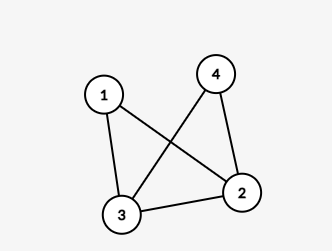

可以用+1的代价用一个4-clique覆盖到这张图。（这里的代价指对objective的影响）

但无法用上述办法覆盖到这个4-clique

---

Q: 如果限定了可以使用的clique，如何做到使用$k$个clique后objective最小

## 1 贪心

记当前图中$weight >0$的边为$+1$，反之为$-1$，每次选weight和最大的clique

这样做问题其实很明显，顶多算是一个还算好的feasible solution

一个可能不太恰当的例子，$k=5$
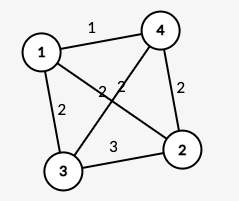

贪心:(1,2,3,4),(1,2,3),(2,3,4),(1,2),(1,3)   obj = 2

最好的解:(1,2,3,4),(1,2,3),(2,3),(3,4),(2,4)  obj = 0

观察到，贪心无法根据k的大小做决策。刚开始选太多很大的clique，可能会导致最后的选择很差

注意到，每个点的contribute是单调递减的，如果上一次的contribute已经不如这次贪心了，就可以略过？



## 2 启发式搜索？

写一个估值函数然后搜，比如，每次记录一个三元组(G,obj,k)，表示目前的图$G$，$objective$和还能覆盖$k$个clique，然后写一个类似这样的f

$$f(obj, k) = a \times obj + b \times k$$

（只是举例子，肯定不能是线性的）

然后根据f来选择下一次往那边搜

初步估计代价很大（记录G是$n^2$的代价，会导致搜索一步的代价就难以承受，并且给$k$写一个很好的估值也很困难

开摆！

## 3 贪心+local search？

贪心找出一个feasible solution，然后local search

额，算子怎么办，第三个数据，clique数有180w个，肯定不能是选两个clique

# 重构思路
1. 只记录(i, j) i<j 的无向边(这个只改了run里的，前面初始化做了双向边，但对run没啥没影响)

2. 对于每条边e，记录对应的clique数量（if e in clique_i, add clique_i to edge_to_clique)

$max_e$ edge_to_clique[e] = 50  (观察出来的)

3. 每次更新，找到最大贡献的clique，然后更新其它所有与它相关的clique

假设最大贡献的clique是k-clique，更新所需要的次数是$50k^2$，为了避免下次需要再排序，用AVL Tree维护。复杂度是$50k^2\log m$, m = valid_cliques_number

感觉应该不慢

一些细节

1. clique_cover()加了arg: max_clique_size


